# Implementation Exercise: Work in Progress
### _Return Predictability and Dynamic Asset Allocation: How Often Should Investors Rebalance?_
by _Himanshu Almadi, David E. Rapach, and Anil Suri_

## 1. Processing data from Bloomberg Terminal

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
from cvxopt import matrix, solvers
from gurobipy import *

In [5]:
def process_xlsx(filename,filetype = 'Bloomberg'):
    """
    process .xlsx files downloaded from Bloomberg and Factset
    """
    file = './data/' + filename
    if filetype == 'Bloomberg':
        df = pd.read_excel(file,header=5)
        df.rename(columns = {'Unnamed: 0':'dates'},inplace=True)
        df.loc[:,'Dates']=pd.to_datetime(df['Dates'])
    if filetype == 'Bonds':
        df = pd.read_excel(file,header=3,parser='Date')
    if filetype == 'Bills':
        df = pd.read_excel(file,header=20,parser='Date')
    return df.reset_index(drop=True)

In [7]:
other_df = process_xlsx('others.xlsx')
other_df.head()

,Dates,SPX Index,SPXDIV Index,CPI INDX Index,CT10 Govt,CB3 Govt,MOODCBAA Index,MOODCAAA Index,IP Index
0,NaT,329.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1990-02-28,331.89,NaN,128.0,NaN,NaN,10.14,9.22,64.0446
2,1990-03-30,339.94,0.31,128.6,NaN,NaN,10.21,9.37,64.3580
3,1990-04-30,330.80,0.98,128.9,NaN,NaN,10.30,9.46,64.2602
4,1990-05-31,361.23,2.74,129.1,NaN,NaN,10.41,9.47,64.3973


In [8]:
df_bonds = process_xlsx('./facset/US10YY-TU1.xlsx','Bonds')
df_bonds.head()

,Date,Close,Volume,Change,% Change,Total Return (Gross),Cumulative Return %,Open,High,Low
0,1990-01-31,8.43,NaN,NaN,NaN,8.43,0.000000,NaN,NaN,NaN
1,1990-02-28,8.51,NaN,0.080000,0.948991,8.51,0.948992,NaN,NaN,NaN
2,1990-03-30,8.65,NaN,0.139999,1.645116,8.65,2.609727,NaN,NaN,NaN
3,1990-04-30,9.04,NaN,0.390000,4.508675,9.04,7.236062,NaN,NaN,NaN
4,1990-05-31,8.60,NaN,-0.440000,-4.867252,8.60,2.016607,NaN,NaN,NaN


In [9]:
df_bill = process_xlsx('./facset/TRYUS3M-FDS.xlsx','Bills')
df_bill.head()

,Date,Close,Volume,Change,% Change,Total Return (Gross),Cumulative Return %,Open,High,Low
0,1990-01-31,7.74,NaN,NaN,NaN,7.74,0.000000,NaN,NaN,NaN
1,1990-02-28,7.77,NaN,0.03,0.387600,7.77,0.387597,NaN,NaN,NaN
2,1990-03-30,7.80,NaN,0.03,0.386103,7.80,0.775194,NaN,NaN,NaN
3,1990-04-30,7.79,NaN,-0.01,-0.128208,7.79,0.645995,NaN,NaN,NaN
4,1990-05-31,7.75,NaN,-0.04,-0.513478,7.75,0.129199,NaN,NaN,NaN


## 2. Processing Explanatory Variables

### 2.1 log(D/P)

More specifically, I am computing the following:
$$ log(\sum_{s=1}^{12} D_{t-(s-1)}) - log(P_{t}) $$
where `D` stands for dividens paid by `SP500` constituents at time t. 
And `P` stands for `SP500` at time t.


As a sanity check, I wanted to check there are only two `NaN` values for `SPXDIV Index`

In [10]:
other_df['SPXDIV Index'].isna().sum()

2

In [11]:
other_df.head()

,Dates,SPX Index,SPXDIV Index,CPI INDX Index,CT10 Govt,CB3 Govt,MOODCBAA Index,MOODCAAA Index,IP Index
0,NaT,329.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1990-02-28,331.89,NaN,128.0,NaN,NaN,10.14,9.22,64.0446
2,1990-03-30,339.94,0.31,128.6,NaN,NaN,10.21,9.37,64.3580
3,1990-04-30,330.80,0.98,128.9,NaN,NaN,10.30,9.46,64.2602
4,1990-05-31,361.23,2.74,129.1,NaN,NaN,10.41,9.47,64.3973


In [12]:
df = pd.DataFrame([])
df['Dates'] = other_df['Dates']
df['log_DP'] = (other_df['SPXDIV Index'].rolling(12).sum().apply('log').shift()
                - other_df['SPX Index'].apply('log'))

In [13]:
df[['Dates','log_DP']][13:].head()

,Dates,log_DP
13,1991-02-28,NaN
14,1991-03-29,-3.184739
15,1991-04-30,-3.187664
16,1991-05-31,-3.221650
17,1991-06-28,-3.175793


Compare 14th row with following for sanity check:

In [14]:
np.log(sum(other_df['SPXDIV Index'][2:14])) - np.log(other_df['SPX Index'][14])

-3.1847388834548687

### 2.2 Inflation

Inflation is calculated by CPI Index. The research paper writes following: 
<br>
_We account for the delay in the release of monthly CPI data when computing the forecast_
<br>
My susequent search suggested that  CPI Index is released with lag of 1 month.
<br>
Thus, I adjust for the issue by shifting CPI Index level by 1.
$$ inflation_{t} = \frac{CPI_{t}}{CPI_{t-1}}$$
However, at time t, the most recent available inflation rate is that of time t-1.


In [15]:
df['inflation'] = other_df['CPI INDX Index'].pct_change().shift()

In [16]:
df[['Dates','inflation']].head()

,Dates,inflation
0,NaT,NaN
1,1990-02-28,NaN
2,1990-03-30,NaN
3,1990-04-30,0.004687
4,1990-05-31,0.002333


Following is a sanity check. inflation rate for 2nd row is consistent with third row of inflation columns. The rationale for this is explained at the Markdown Cell above

In [17]:
(other_df['CPI INDX Index'][2]/other_df['CPI INDX Index'][1] -1)

0.004687499999999956

### 2.3 Term Spread

Term spread refers to the difference between 10-year Treasury bond yield and the three-month Treasury bill yield.


In [18]:
df['Term_Spread'] = df_bonds['Close'] - df_bill['Close']

In [19]:
df[['Dates','Term_Spread']].head()

,Dates,Term_Spread
0,NaT,0.690001
1,1990-02-28,0.740000
2,1990-03-30,0.849999
3,1990-04-30,1.250000
4,1990-05-31,0.850000


### 2.4 Default Spread

The difference between Moody's BAA and AAA rated corporate Bond yields

In [20]:
df['Default_Spread']=other_df['MOODCBAA Index'] - other_df['MOODCAAA Index']

In [21]:
df[['Dates','Default_Spread']].head()

,Dates,Default_Spread
0,NaT,NaN
1,1990-02-28,0.92
2,1990-03-30,0.84
3,1990-04-30,0.84
4,1990-05-31,0.94


As with `term spread`, a few observation would be sufficient for a sanity check as it only requires a subtraction

In [22]:
other_df[['Dates','MOODCBAA Index','MOODCAAA Index']].head()

,Dates,MOODCBAA Index,MOODCAAA Index
0,NaT,NaN,NaN
1,1990-02-28,10.14,9.22
2,1990-03-30,10.21,9.37
3,1990-04-30,10.30,9.46
4,1990-05-31,10.41,9.47


### 2.5  Moving Averages

Average of `SPX Index` for the past 12-months.
<br>
$$ MA_{t} = \frac{\sum_{i=0}^{11} SPX_{t-i}}{12}$$

In [23]:
Moving_Average_12 = other_df['SPX Index'].rolling(12).mean()

In [24]:
Moving_Average_12[10:].head()

10           NaN
11    332.680000
12    333.917500
13    336.849167
14    339.789167
Name: SPX Index, dtype: float64

As a sanity check: the moving average of first 12 numbers are as following:

In [25]:
np.mean(other_df['SPX Index'][:12])

332.68000000000006

In [26]:
Moving_Average_2 = other_df['SPX Index'].rolling(2).mean()

In [27]:
Moving_Average_2.head()

0        NaN
1    330.485
2    335.915
3    335.370
4    346.015
Name: SPX Index, dtype: float64

As a sanity check: the moving average of first 12 numbers are as following:

In [28]:
np.mean(other_df['SPX Index'][:2])

330.485

In [29]:
Bond_Moving_Average_12 = df_bonds['Close'].rolling(12).mean()

In [30]:
Bond_Moving_Average_12[10:].head()

10         NaN
11    8.557500
12    8.524167
13    8.483333
14    8.433333
Name: Close, dtype: float64

As a sanity check: the moving average of first 12 numbers are as following:

In [31]:
df_bonds['Close'][:12].mean()

8.557499965031942

In [32]:
Bond_Moving_Average_6 = Bond_Moving_Average_12 = df_bonds['Close'].rolling(6).mean()

In [33]:
Bond_Moving_Average_6[5:].head()

5    8.610000
6    8.598333
7    8.656667
8    8.685000
9    8.620000
Name: Close, dtype: float64

In [34]:
np.mean(df_bonds['Close'][:6])

8.610000133514404

### 2.5.1 MA(1,12) 

It is a dummy variable based on `SPX Index` level and `Moving_Average_12`
<br>
If `SPX Index` value is greater than its 12 months moving average, then assign 1. Otherwise assign 0.

In [35]:
MA_nan = (other_df['SPX Index']-Moving_Average_12).apply(lambda x: np.nan if np.isnan(x) else 0)

In [36]:
df['MA_1_12']=(other_df['SPX Index']-Moving_Average_12).apply(lambda x: 1 if x>0 else 0) + MA_nan

In [37]:
df[['Dates','MA_1_12']][9:].head()

,Dates,MA_1_12
9,1990-10-31,NaN
10,1990-11-30,NaN
11,1990-12-31,0.0
12,1991-01-31,1.0
13,1991-02-28,1.0


As a sanity check, since Moving_Average_12 is already checked, following shows that lambda function performs as expected.

In [38]:
(other_df['SPX Index']-Moving_Average_12)[9:].head()

9           NaN
10          NaN
11    -2.460000
12    10.012500
13    30.220833
Name: SPX Index, dtype: float64

### 2.5.2 MA(2,12) 

It is a dummy variable based on `Moving_Average_2`  and `Moving_Average_12`
<br>
If `Moving_Average_2` value is greater than `Moving_Average_12` value, then assign 1. Otherwise assign 0.

In [39]:
df['MA_2_12']=(Moving_Average_2-Moving_Average_12).apply(lambda x: 1 if x>0 else 0) + MA_nan

In [40]:
df[['Dates','MA_2_12']][9:].head()

,Dates,MA_2_12
9,1990-10-31,NaN
10,1990-11-30,NaN
11,1990-12-31,0.0
12,1991-01-31,1.0
13,1991-02-28,1.0


### 2.5.3 MOMBY(6) 

It is a dummy variable based on `Bond_Moving_Average_6`  and the current bond yield.
<br>
If the bond yield is greater than `Bond_Moving_Average_6` by more than 5 basis points, assign -1. 
<br>
Else if the bond yield is less than `Bond_Moving_Average_6` by more than 5 basis points, assign 1.
<br>
Otherwie, assign 0.

In [41]:
MOMBY_6_nan = (df_bonds['Close']-Bond_Moving_Average_6
              ).apply(lambda x: np.nan if np.isnan(x) else 0)

In [42]:
df['MOMBY_6']=(df_bonds['Close']-Bond_Moving_Average_6
              ).apply(lambda x: -1 if x>0.05 else (1 if x<0.05 else 0)) + MOMBY_6_nan

In [43]:
df[['Dates','MOMBY_6']][5:].head()

,Dates,MOMBY_6
5,1990-06-29,1.0
6,1990-07-31,1.0
7,1990-08-31,-1.0
8,1990-09-28,-1.0
9,1990-10-31,1.0


### 2.5.3 MOMBY(12) 

In [44]:
MOMBY_12_nan = (df_bonds['Close']-Bond_Moving_Average_12
              ).apply(lambda x: np.nan if np.isnan(x) else 0)

In [45]:
df['MOMBY_12']=(df_bonds['Close']-Bond_Moving_Average_12
              ).apply(lambda x: -1 if x>0.05 else (1 if x<0.05 else 0)) + MOMBY_12_nan

In [46]:
df[['Dates','MOMBY_12']][11:].head()

,Dates,MOMBY_12
11,1990-12-31,1.0
12,1991-01-31,1.0
13,1991-02-28,1.0
14,1991-03-29,1.0
15,1991-04-30,1.0


### 2.6 MOM

It is a dummy variable that depends on `SPX Index` and its lagged values.

### 2.6.1 MOM(9)
If the difference between `SPX Index` and its 9 months lagged value is positive then assign 1. Otherwise assign 0.

In [47]:
MOM_9_nan = (other_df['SPX Index']-other_df['SPX Index'].shift(9)
            ).apply(lambda x: np.nan if np.isnan(x) else 0)
df['MOM_9']=(other_df['SPX Index']-other_df['SPX Index'].shift(9)
            ).apply(lambda x: 1 if x>0 else 0) + MOM_9_nan

In [48]:
df[['Dates','MOM_9']][8:].head()

,Dates,MOM_9
8,1990-09-28,NaN
9,1990-10-31,0.0
10,1990-11-30,0.0
11,1990-12-31,0.0
12,1991-01-31,1.0


Following checks the result

In [49]:
(other_df['SPX Index']-other_df['SPX Index'].shift(9))[8:].head()

8       NaN
9    -25.08
10    -9.67
11    -9.72
12    13.13
Name: SPX Index, dtype: float64

### 2.6.2 MOM(12)
If the difference between `SPX Index` and its 12 months lagged value is positive then assign 1. Otherwise assign 0.

In [50]:
MOM_12_nan = (other_df['SPX Index']-other_df['SPX Index'].shift(12)
            ).apply(lambda x: np.nan if np.isnan(x) else 0)
df['MOM_12']=(other_df['SPX Index']-other_df['SPX Index'].shift(12)
            ).apply(lambda x: 1 if x>0 else 0) + MOM_12_nan

In [51]:
df[['Dates','MOM_12']][11:].head()

,Dates,MOM_12
11,1990-12-31,NaN
12,1991-01-31,1.0
13,1991-02-28,1.0
14,1991-03-29,1.0
15,1991-04-30,1.0


### 2.7 Output Gap

The deviation of the log of industrial production from a quadratic trend.
<br>
I believe this data is available from Bloomberg Terminal. 
However, it is simple to compute. Therefore, I decided to simply compute it.
<br>
A quadratic trend is of the following form:
<br>
$$ y_{t} = \beta_{0} + \beta_{0}x_{t} + \beta_{0}x_{t}^2 +\epsilon_{t} $$
<br>
$\widehat{\beta}$ is estimated by $$\widehat{\beta} = (X^{T}X)^{-1}X^{T}y  $$

following provides an illustration of this estimation procedure.



In [52]:
def beta_est(obs):
    """
    estimates beta of ols to minimize l2 norm
    """
    y = np.log(other_df['IP Index'].dropna())[:obs]
    X = np.concatenate((np.ones(obs).reshape(-1,1),np.arange(obs).reshape(-1,1)),axis=1)
    X = np.concatenate((X,(np.arange(obs)**2).reshape(-1,1)),axis=1)
    beta_hat = np.dot(np.matmul(np.linalg.inv(1e-6 *np.eye(3) + np.matmul(X.transpose(),X)),
                                X.transpose()),y.values.reshape(-1,1))
    return beta_hat

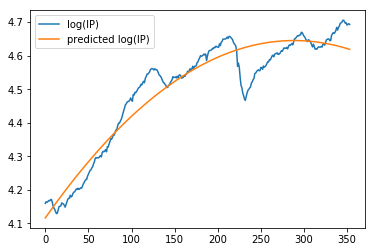

In [53]:
n = len(np.log(other_df['IP Index'].dropna()))
X = np.concatenate((np.ones(n).reshape(-1,1),np.arange(n).reshape(-1,1)),axis=1)
X = np.concatenate((X,(np.arange(n)**2).reshape(-1,1)),axis=1)
beta_hat = beta_est(n)
y_pred = np.matmul(X,beta_hat)
y = np.log(other_df['IP Index'].dropna())
plot_df = np.concatenate((np.arange(n).reshape(-1,1),y.values.reshape(-1,1),y_pred),axis=1)
plot_df = pd.DataFrame(plot_df)
plot_df.columns = ['obs','log(IP)','predicted log(IP)']
plt.plot('obs','log(IP)',data=plot_df)
plt.plot('obs','predicted log(IP)',data=plot_df)
plt.legend()

However, the research estimates $\widehat{\beta}$ from data available up to each point in time. Thus, I will repeat the calculation above to every time step.

In [54]:
def output_gap_computer(obs):
    """
    computes the deviation of the log of industrial production from a quadratic trend.
    """
    return y[obs]-np.dot(X[:obs],beta_est(obs))[-1]

In [55]:
# Next Cell parallelize for loop. It is equivalent to

# output_gap2 = []
# for i in range(1,n+1):
#     output_gap2 += [output_gap_computer(i)]

In [56]:
pool = multiprocessing.Pool(4)
output_gap =[*pool.map(output_gap_computer, range(1, n+1))]

In [57]:
df['output_gap']=np.concatenate(([np.nan],np.array(output_gap).reshape(-1)))

In [58]:
df[['Dates','output_gap']].head()

,Dates,output_gap
0,NaT,NaN
1,1990-02-28,4.159576e-06
2,1990-03-30,2.422823e-09
3,1990-04-30,-5.646037e-09
4,1990-05-31,5.029228e-04


### 2.7 SPX Index return


In [59]:
df['r_SPX'] = other_df['SPX Index'].pct_change().shift(-1)
df[['Dates','r_SPX']].head()

,Dates,r_SPX
0,NaT,0.008539
1,1990-02-28,0.024255
2,1990-03-30,-0.026887
3,1990-04-30,0.091989
4,1990-05-31,-0.008886


### 2.8 Bond return and yield

In [60]:
def compound_return(cum_return):
    sol = (cum_return.values/100 + 1)
    for i in range(2,len(sol)):
       sol[i] = sol[i]/(cum_return.values/100 + 1)[i-1]
    return sol - 1


In [61]:
df['y_bond'] = df_bonds['Close']/100
df[['Dates','y_bond']].head()

,Dates,y_bond
0,NaT,0.0843
1,1990-02-28,0.0851
2,1990-03-30,0.0865
3,1990-04-30,0.0904
4,1990-05-31,0.0860


In [65]:
df['r_bond'] = compound_return(df_bonds['Cumulative Return %'].shift(-1))
df[['Dates','r_bond']].head()

,Dates,r_bond
0,NaT,0.009490
1,1990-02-28,0.026097
2,1990-03-30,0.045087
3,1990-04-30,-0.048673
4,1990-05-31,-0.019767


To check the compound_return function indeed takes cumulative return as input and computes the compounding rate of return: I will manually compute `r_bond` on `1990-03-30`. The numbers correspond to cumulative returns as can be seen from the cell below:
<br>
$$ (1.026097) = (1.009490)(1 + r) \Rightarrow r = 0.016451$$
$$ (1.072361) = (1.009490)(1.016451)(1 + r) \Rightarrow r = 0.045087 $$



In [66]:
(df_bonds['Cumulative Return %']/100 + 1).head()

0    1.000000
1    1.009490
2    1.026097
3    1.072361
4    1.020166
Name: Cumulative Return %, dtype: float64

### 2. Bill return and yield

In [67]:
df['y_bill'] = df_bill['Close']/100
df[['Dates','y_bill']].head()

,Dates,y_bill
0,NaT,0.0774
1,1990-02-28,0.0777
2,1990-03-30,0.0780
3,1990-04-30,0.0779
4,1990-05-31,0.0775


,Dates,r_bill
0,NaT,0.003876
1,1990-02-28,0.007752
2,1990-03-30,-0.001282
3,1990-04-30,-0.005135
4,1990-05-31,-0.001290


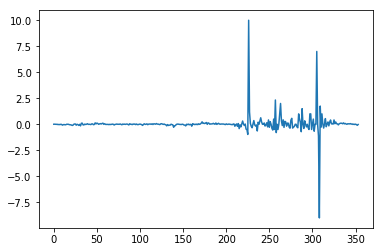

In [68]:
df['r_bill'] = compound_return(df_bill['Cumulative Return %'].shift(-1))
plt.plot(df['r_bill'])
df[['Dates','r_bill']].head()

To check the compound_return function indeed takes cumulative return as input and computes the compounding rate of return: I will manually compute `r_bill` on `1990-03-30`. The numbers correspond to cumulative returns as can be seen from the cell below:
<br>
$$ (1+ 0.007752) = (1 + 0.003876)(1 + r) \Rightarrow r = 0.003861$$
$$ (1 + 0.006460) = (1 + 0.003876)(1 + 0.003861)(1 + r) \Rightarrow r = -0.001282 $$



In [69]:
(df_bill['Cumulative Return %']/100 + 1).head()

0    1.000000
1    1.003876
2    1.007752
3    1.006460
4    1.001292
Name: Cumulative Return %, dtype: float64

In [70]:
1.006460/((1+0.003861)*(1+0.003876)) -1

-0.001282027007208475

## 3. Return Forecasts

After preprocessing available data is from 1991-03-29 to 2019-07-31

In [78]:
processed_df = df.loc[14:353].reset_index(drop=True)
processed_df.tail()

,Dates,log_DP,inflation,Term_Spread,Default_Spread,MA_1_12,MA_2_12,MOMBY_6,MOMBY_12,MOM_9,MOM_12,output_gap,r_SPX,y_bond,r_bond,y_bill,r_bill
335,2019-02-28,-3.780938,-0.000198,0.3123,1.16,1.0,1.0,1.0,1.0,1.0,1.0,0.083610,0.017924,0.027123,-0.109354,0.0240,-0.020833
336,2019-03-29,-3.785870,0.001741,0.0657,1.07,1.0,1.0,1.0,1.0,1.0,1.0,0.083278,0.039313,0.024157,0.035393,0.0235,0.012766
337,2019-04-30,-3.818848,0.004089,0.1212,1.01,1.0,1.0,1.0,1.0,1.0,1.0,0.075730,-0.065778,0.025012,-0.143651,0.0238,-0.033613
338,2019-05-31,-3.740195,0.003187,-0.1581,0.96,0.0,1.0,1.0,1.0,0.0,1.0,0.076963,0.068930,0.021419,-0.066997,0.0230,-0.095652
339,2019-06-28,-3.792573,0.000773,-0.0816,1.04,1.0,1.0,1.0,1.0,1.0,1.0,0.077539,0.013128,0.019984,0.010308,0.0208,-0.019231


### 3.1 Stock Returns

First step is to find truncated PCA for different number of eigenvalues.
<br>
PCA is implemented on the following matrix. Each variable corresponds to a set of observations and hence is a column vector.
<br>
[ $log(\frac{D}{P})$, Inflation, Term Spread, Default Spread, Output Gap, MA(1,12), MA(2,12), MOM(9), MOM(12) ] 
<br>

Second step is to come up with a decision rule on how to truncate eigenvalues.
The research paper utilizes (1) out-of-sample $R^2$ denoted as $R_{OS}^2$ and (2) Clark and West statistic.
<br>
where 
$$R_{OS}^2 = 1 - \frac{\sum_{t=1}^T (r_{t} - \widehat{r}_{t})}{\sum_{t=1}^T (r_{t} - \overline{r}_{t-1})} $$
and
<br>
<br>
$\widehat{r}_{t}$ is the fitted value using data up to t-1
<br>
$\overline{r}_{t-1}$ is the historal average using data upto t-1
<br>
<br>
Apart from $R_{OS}^2$, the paper utilizes Clark and West (2007) test. 
<br> Refer: Approximately Normal Tests for Equal Predictive Accuracy in Nested Models.
<br> Clark and West claims that test of mean squared prediction error (MSPE) typically exhibits a stylised pattern. That is, `the MSPE under Null (parsimonious model) is relatively smaller than it is expected to be because of the efficiency of parsimonious model and noises from estimating more parameters`. Therefore, authors propose an alternative hypothesis test as following:
<br>
For the hypothesis testing <br>H0: Parsimonious model (constant) MSPE is equal to or better than that of the larger model, H1: Larger model is better.
$$ \hat{f}_{t+1} = (y_{t+1} - \hat{y}_{\text{pars:} t,t+1})^2 - [(y_{t+1} - \hat{y}_{\text{large:} t,t+1})^2 - (\hat{y}_{\text{pars:} t,t+1} - \hat{y}_{\text{large:} t,t+1})^2] $$
$$ \overline{f} = \frac{1}{T}\sum_{t=1}^{T}\hat{f}_{t+1}$$
$$ s_{\hat{f}-\overline{f}}^2 = \frac{1}{T-1}\sum_{t=1}^{T}(\hat{f}_{t+1}-\overline{f})^2 $$

<br>Test statistics is: $$ CW = \frac{\overline{f}}{s_{\hat{f}-\overline{f}}/\sqrt{T}}$$ <br> the mean of $\hat{f}_{t+\tau}$ denoted as $\overline{\hat{f}_{t+\tau}}$ . With 10% significance level, reject null if $\overline{\hat{f}_{t+\tau}}$ > 1.282. With 5% significance level, reject null if $\overline{\hat{f}_{t+\tau}}$ > 1.645. For one step forecast errors, the usual least squares standard errors can be used. For autocorrelated forecast errors, an autocorrelation consistent standard error should be used.

In [79]:
def truncated_PC(X,dim):
    eig, V = np.linalg.eig(np.matmul(X.transpose(),X))
    approx_X =  np.matmul(X,V[:,:dim])
    return approx_X

In [80]:
def PC_approx_error(X,dim):
    """
    PC approximation errors in terms of frobenius norms
    """
    eig, V = np.linalg.eig(np.matmul(X.transpose(),X))
    approx_A =  np.matmul(np.matmul(V[:,:dim],
                            np.diag(eig[:dim])),
                            V[:,:dim].transpose())
    error = np.linalg.norm(approx_A - np.matmul(X.transpose(),X), ord='fro')
    return error

In [81]:
def PC_fit(X,r,dim):
    """
    estimates SPX Index return in a way that minimizes l2 norm
    """
    X = np.concatenate((np.ones(X.shape[0]).reshape(-1,1),X),axis=1)
    beta = \
    np.matmul(
        np.linalg.inv(1e-6*np.eye(dim+1) + np.matmul(X.transpose(),X)),
        np.matmul(X.transpose(),r))
    return beta

### 3.1.1 Principle Component Regression

In [82]:
stock_explanatory_variables = ['log_DP','inflation','Term_Spread','Default_Spread',\
                               'output_gap','MA_1_12','MA_2_12','MOM_9','MOM_12']
X = processed_df[stock_explanatory_variables].values

The plot of PC approximation errors in terms of frobenius norm is as following:

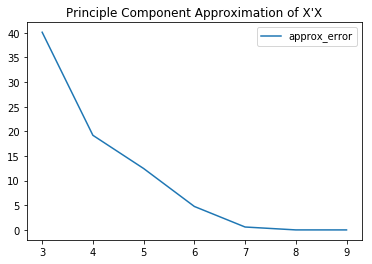

In [83]:
PC_plot_df = pd.DataFrame([])
PC_plot_df['dim'] = range(3,X.shape[1]+1) 
PC_plot_df['approx_error'] = [PC_approx_error(X,dim) for dim \
                               in range(3,X.shape[1]+1)]
plt.plot('dim','approx_error',data=PC_plot_df)
plt.title("Principle Component Approximation of X'X")
plt.legend()

Above plot confirms that the principle component approximation works as expected

Following figures compare actual return with estimated return based on PC regression.

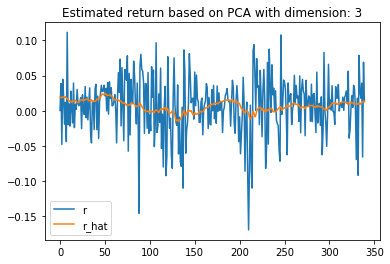

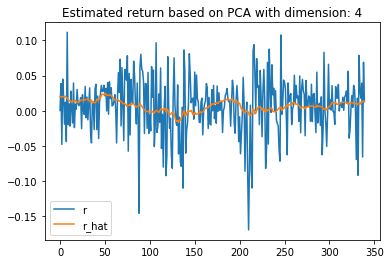

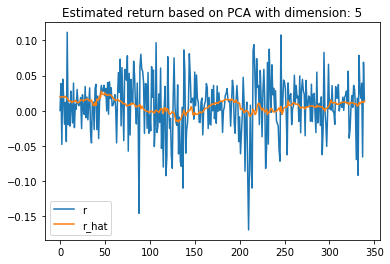

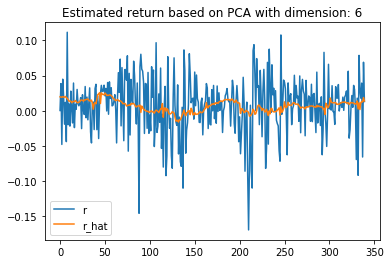

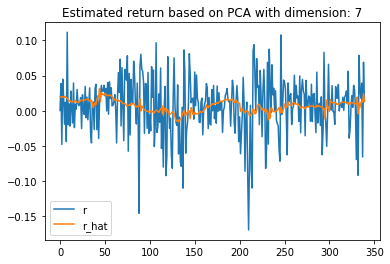

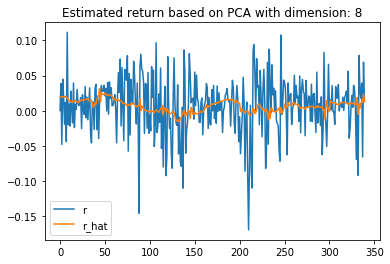

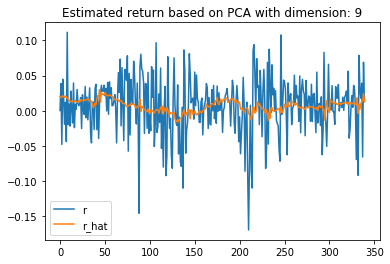

In [84]:
for i in range(3,10):
    dim = i
    r = processed_df['r_SPX'].values
    X_PCA = truncated_PC(X,dim)
    w = PC_fit(X_PCA,r,dim)
    X_PCA_intercept = np.concatenate((np.ones(X_PCA.shape[0]).reshape(-1,1),X_PCA),axis=1)
    r_hat = np.matmul(X_PCA_intercept,w)
    plt.figure(i)
    PC_plot_df2 = pd.DataFrame([])
    PC_plot_df2['r_hat'] = r_hat
    PC_plot_df2['r'] = r
    plt.plot('r',data=PC_plot_df2)
    plt.plot('r_hat',data=PC_plot_df2)
    plt.title(f'Estimated return based on PCA with dimension: {dim}')
    plt.legend()


### 3.1.2  $R_{OS}^2$ Computation

Following the logic of the original paper, I will compute $R_{OS}^2$ for monthly (h=1), quartherly (h=3), semi-annual (h=6), and annual (h=12). And out-of-sample forecasts are estimated by recursive estimation windows. For example, for monthly estimation, initial 200 samples are used exclusively for fitting the model. The 201$^{\text{st}}$ sample is forecasted by the model fitted by 200 samples. The 202$^{\text{nd}}$ sample is estimated by the model fitted using 201 samples. And so on.
<br>
<br>
Below illustrations show that monthly $R_{OS}^2$ gives the highest value range. This is consistent with the original paper. 

In [85]:
X[:200].shape

(200, 9)

In [86]:
def Rsquared_OS(X,r,dim,OS_start):
    """
    computes out-of-sample rsquared.
    First computes PCA only using explanatory variables without augmenting the data with a constant = 1.
    For regression result, added a constant to capture the y-intercept. 
    PCA_fit by default adds the constant column. Therefore, I only add the constant column to obtain
    one step ahead forecast using the weights obtained by the PCA_fit
    """
    numerator = 0
    denominator = 0
    for i in range(OS_start,len(r)):
        X_PCA = truncated_PC(X[:i],dim)
        w = PC_fit(X_PCA,r[:i],dim) 
        X_PCA_OS = truncated_PC(X[:i+1],dim)
        X_PCA_OS_intercept = np.concatenate((np.ones(X_PCA_OS.shape[0]).reshape(-1,1),X_PCA_OS),axis=1)
        r_hat = np.matmul(X_PCA_OS_intercept[-1],w)
        numerator += (r[i] - r_hat)**2
        denominator += (r[i]-r[:i].mean())**2
    R_squared_OS = 1 - numerator/(denominator + 1e-6)
    return R_squared_OS

### 3.1.2.1 Month $R_{OS}^2$ 

Text(0.5, 1.0, 'Month out-of-sample R-squared')

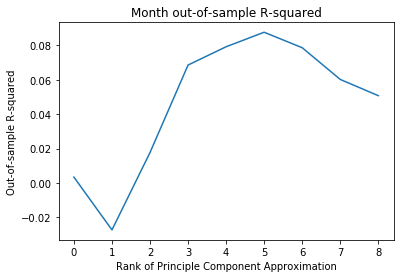

In [87]:
plt.plot([Rsquared_OS(X,r,i,200) for i in range(1,X.shape[1]+1)])
plt.xlabel('Rank of Principle Component Approximation')
plt.ylabel('Out-of-sample R-squared')
plt.title('Month out-of-sample R-squared')

### 3.1.2.2  Quarter $R_{OS}^2$

For consistency, I utilized 66 quarterly observations exclusively for fitting the model. Following dataframe shows that 66$^{\text{th}}$ quarterly observation corresponds to 200$^{\text{th}}$ monthly observation.

In [88]:
processed_df[2:].reset_index().set_index('Dates').resample('3M').agg('last').reset_index()[64:].head()

,Dates,index,log_DP,inflation,Term_Spread,Default_Spread,MA_1_12,MA_2_12,MOMBY_6,MOMBY_12,MOM_9,MOM_12,output_gap,r_SPX,y_bond,r_bond,y_bill,r_bill
64,2007-05-31,194,-3.843610,0.003001,0.2994,0.92,1.0,1.0,-1.0,-1.0,1.0,1.0,0.021707,-0.017816,0.048994,0.025942,0.0460,0.017391
65,2007-08-31,197,-3.779418,0.001781,0.6221,0.86,1.0,1.0,1.0,1.0,1.0,1.0,0.018905,0.035794,0.045321,0.012886,0.0391,-0.048593
66,2007-11-30,200,-3.788723,0.003083,0.8589,0.96,1.0,1.0,1.0,1.0,1.0,1.0,0.019589,-0.008628,0.039389,0.034807,0.0308,0.068182
67,2008-02-29,203,-3.710938,0.003448,1.7002,1.29,0.0,0.0,1.0,1.0,0.0,0.0,0.009492,-0.005960,0.035102,-0.027862,0.0181,-0.248619
68,2008-05-31,206,-3.774398,0.002314,2.2153,1.36,0.0,0.0,-1.0,-1.0,0.0,0.0,-0.008239,-0.085962,0.040653,-0.023442,0.0185,0.010811


Text(0.5, 1.0, 'Quarter out-of-sample R-squared')

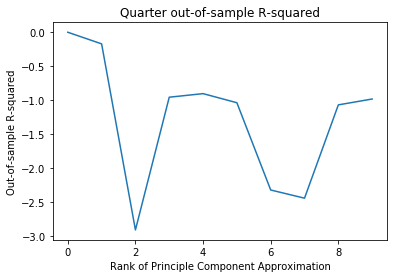

In [89]:
X_quarter = processed_df[2:].set_index('Dates').resample('3M').agg('last')[stock_explanatory_variables].values
r_quarter = processed_df[2:].set_index('Dates').resample('3M').agg('last')['r_SPX'].values
plt.plot([Rsquared_OS(X_quarter,r_quarter,i,66) for i in range(X.shape[1]+1)])
plt.xlabel('Rank of Principle Component Approximation')
plt.ylabel('Out-of-sample R-squared')
plt.title('Quarter out-of-sample R-squared')

### 3.1.2.3  Semi-annual $R_{OS}^2$

For consistency, I utilized 33 semi-annually observations exclusively for fitting the model. Following dataframe shows that 33$^{\text{rd}}$ quarterly observation corresponds to 200$^{\text{th}}$ monthly observation.

In [90]:
processed_df[2:].reset_index().set_index('Dates').resample('6M').agg('last').reset_index()[32:].head()

,Dates,index,log_DP,inflation,Term_Spread,Default_Spread,MA_1_12,MA_2_12,MOMBY_6,MOMBY_12,MOM_9,MOM_12,output_gap,r_SPX,y_bond,r_bond,y_bill,r_bill
32,2007-05-31,194,-3.843610,0.003001,0.2994,0.92,1.0,1.0,-1.0,-1.0,1.0,1.0,0.021707,-0.017816,0.048994,0.025942,0.0460,0.017391
33,2007-11-30,200,-3.788723,0.003083,0.8589,0.96,1.0,1.0,1.0,1.0,1.0,1.0,0.019589,-0.008628,0.039389,0.034807,0.0308,0.068182
34,2008-05-31,206,-3.774398,0.002314,2.2153,1.36,0.0,0.0,-1.0,-1.0,0.0,0.0,-0.008239,-0.085962,0.040653,-0.023442,0.0185,0.010811
35,2008-11-30,212,-3.339371,-0.008598,2.9100,3.09,0.0,0.0,1.0,1.0,0.0,0.0,-0.071761,0.007822,0.029200,-0.295240,0.0001,10.000000
36,2009-05-31,218,-3.346824,0.001007,3.3204,2.52,0.0,0.0,-1.0,-1.0,0.0,0.0,-0.137647,0.000196,0.034604,0.020894,0.0014,0.357143


Text(0.5, 1.0, 'Semi-annual out-of-sample R-squared')

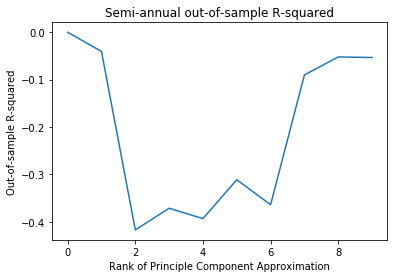

In [91]:
X_semi = processed_df[2:].set_index('Dates').resample('6M').agg('last')[stock_explanatory_variables].values
r_semi = processed_df[2:].set_index('Dates').resample('6M').agg('last')['r_SPX'].values
plt.plot([Rsquared_OS(X_semi,r_semi,i,33) for i in range(X.shape[1]+1)])
plt.xlabel('Rank of Principle Component Approximation')
plt.ylabel('Out-of-sample R-squared')
plt.title('Semi-annual out-of-sample R-squared')

### 3.1.2.4  Annual $R_{OS}^2$

For consistency, I utilized 33 semi-annually observations exclusively for fitting the model. Following dataframe shows that 33$^{\text{rd}}$ quarterly observation corresponds to 200$^{\text{th}}$ monthly observation.

In [92]:
processed_df.reset_index().set_index('Dates').resample('Y').agg(lambda x: x[-2]).reset_index()[15:].head()

,Dates,index,log_DP,inflation,Term_Spread,Default_Spread,MA_1_12,MA_2_12,MOMBY_6,MOMBY_12,MOM_9,MOM_12,output_gap,r_SPX,y_bond,r_bond,y_bill,r_bill
15,2006-12-31,188,-3.814893,-0.004438,-0.4390,0.87,1.0,1.0,1.0,1.0,1.0,1.0,0.006390,0.012616,0.044610,0.050482,0.0490,-0.002041
16,2007-12-31,200,-3.788723,0.003083,0.8589,0.96,1.0,1.0,1.0,1.0,1.0,1.0,0.019589,-0.008628,0.039389,0.034807,0.0308,0.068182
17,2008-12-31,212,-3.339371,-0.008598,2.9100,3.09,0.0,0.0,1.0,1.0,0.0,0.0,-0.071761,0.007822,0.029200,-0.295240,0.0001,10.000000
18,2009-12-31,224,-3.617410,0.003002,3.1402,1.13,1.0,1.0,1.0,1.0,1.0,1.0,-0.077893,0.017771,0.032002,0.197863,0.0006,0.000000
19,2010-12-31,236,-3.755558,0.003482,2.6254,1.05,1.0,1.0,-1.0,-1.0,1.0,1.0,-0.001713,0.065300,0.027954,0.176969,0.0017,-0.294118


/Users/gimdong-geon/python3_cooking/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Annual out-of-sample R-squared')

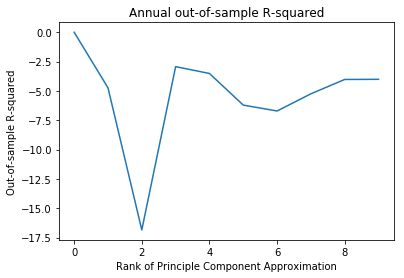

In [93]:
X_annual = (processed_df.set_index('Dates').resample('Y')
            .agg(lambda x: x[-2])[stock_explanatory_variables].values)
r_annual = (processed_df.set_index('Dates').resample('Y')
            .agg(lambda x: x[-2])['r_SPX'].values)
plt.plot([Rsquared_OS(X_annual,r_annual,i,16) for i in range(X.shape[1]+1)])
plt.xlabel('Rank of Principle Component Approximation')
plt.ylabel('Out-of-sample R-squared')
plt.title('Annual out-of-sample R-squared')

### 3.1.3  Clark and Wald (2007) Test Statistics Computation

In [94]:
def CW_test(X,r,dim,OS_start):
    """
    computes Clark and Wald test statistics.
    First computes PCA only using explanatory variables without augmenting the data with a constant = 1.
    For regression result, added a constant to capture the y-intercept. 
    PCA_fit by default adds the constant column. Therefore, I only add the constant column to obtain
    one step ahead forecast using the weights obtained by the PCA_fit

    """
    denom = len(r) - OS_start
    num = []
    for i in range(OS_start,len(r)):
        X_PCA = truncated_PC(X[:i],dim)
        w = PC_fit(X_PCA,r[:i],dim)
        X_PCA_OS = truncated_PC(X[:i+1],dim)
        X_PCA_OS_intercept = np.concatenate((np.ones(X_PCA_OS.shape[0]).reshape(-1,1),X_PCA_OS),axis=1)
        r_hat = np.matmul(X_PCA_OS_intercept[-1],w)
        num += [(r[i]-r[:i].mean())**2 - (r[i] - r_hat)**2  + (r[:i].mean() - r_hat)**2]
    f_bar = np.array(num).mean()
    CW = np.sqrt(denom) * f_bar / np.std(np.array(num) - f_bar,ddof=1)
    return CW

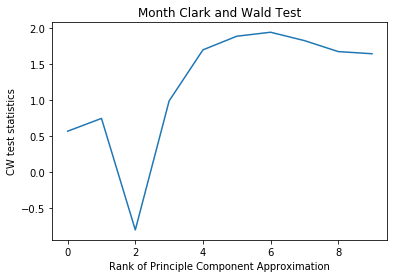

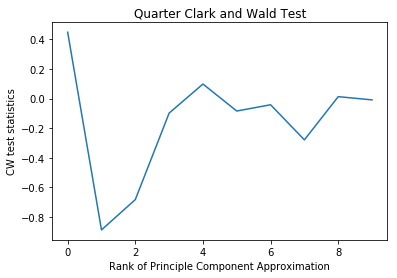

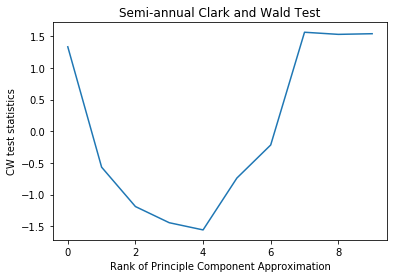

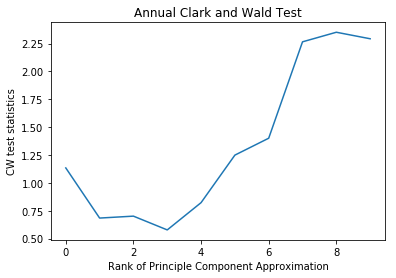

In [95]:
my_dict = {'month':200,'quarter':66,'semi':33,'annual':16}

i=0
for item in my_dict.keys():
    plt.figure(i)
    if item == 'month':
        plt.plot([CW_test(X,r,i,my_dict[item]) for i in range(X.shape[1]+1)])
        plt.xlabel('Rank of Principle Component Approximation')
        plt.ylabel('CW test statistics')
        plt.title('Month Clark and Wald Test')
    else:
        eval(f'plt.plot([CW_test(X_{item},r_{item},i,my_dict[item]) for i in range(X.shape[1]+1)])')
        plt.xlabel('Rank of Principle Component Approximation')
        plt.ylabel('CW test statistics')
        if item == 'semi':
            plt.title(f'{item[0].upper()}{item[1:]}' + '-annual Clark and Wald Test')
        else:
            plt.title(f'{item[0].upper()}{item[1:]} Clark and Wald Test')
    i+=1

### 3.2 Bond Returns

The logic of this section is equivalent to the stock returns. First section deals with principal component, the second section the $R_{OS}^2$ and the third section the Clark Wald test statistics.

In [96]:
bonds_explanatory_variables = ['y_bond','inflation','Term_Spread','Default_Spread',\
                               'output_gap','MOMBY_6','MOMBY_12']
X = processed_df[bonds_explanatory_variables].values
r = processed_df['r_bond'].values

X_quarter = (processed_df[2:].set_index('Dates').resample('3M')
             .agg('last')[bonds_explanatory_variables].values)
y_quarter = (processed_df[2:].set_index('Dates')
             .resample('3M').agg('last')['r_bond'].values)
X_semi = (processed_df[2:].set_index('Dates').resample('6M')
          .agg('last')[bonds_explanatory_variables].values)
y_semi = (processed_df[2:].set_index('Dates')
          .resample('6M').agg('last')['r_bond'].values)
X_annual = (processed_df.set_index('Dates').resample('Y')
        .agg(lambda x: x[-2])[bonds_explanatory_variables].values)
y_annual = (processed_df.set_index('Dates').resample('Y')
        .agg(lambda x: x[-2])['r_bond'].values)


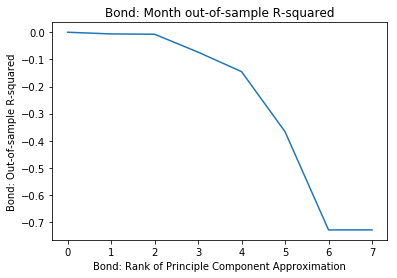

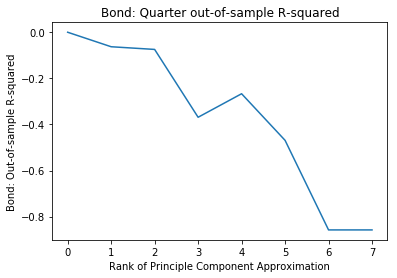

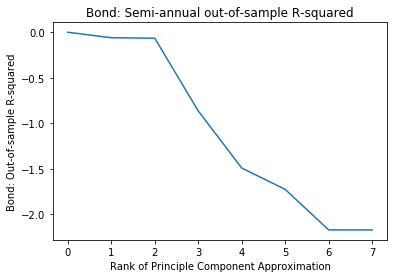

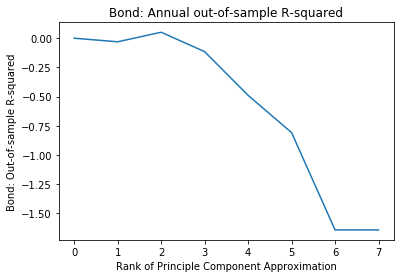

In [97]:
my_dict = {'month':200,'quarter':66,'semi':33,'annual':16}

i=0
for item in my_dict.keys():
    plt.figure(i)
    if item == 'month':
        plt.plot([Rsquared_OS(X,r,i,my_dict[item]) for i in range(X.shape[1]+1)])
        plt.xlabel('Bond: Rank of Principle Component Approximation')
        plt.ylabel('Bond: Out-of-sample R-squared')
        plt.title('Bond: Month out-of-sample R-squared')
    else:
        eval(f'plt.plot([Rsquared_OS(X_{item},r_{item},i,my_dict[item]) for i in range(X.shape[1]+1)])')
        plt.xlabel('Rank of Principle Component Approximation')
        plt.ylabel('Bond: Out-of-sample R-squared')
        if item == 'semi':
            plt.title('Bond: '+f'{item[0].upper()}{item[1:]}' + '-annual out-of-sample R-squared')
        else:
            plt.title('Bond: '+ f'{item[0].upper()}{item[1:]} out-of-sample R-squared')
    i+=1



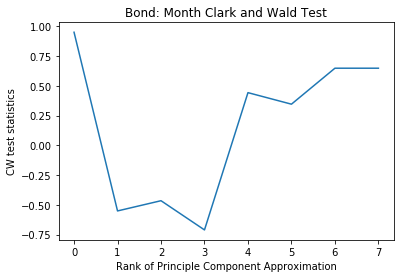

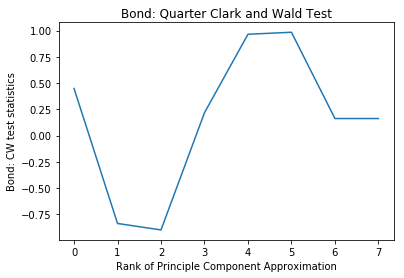

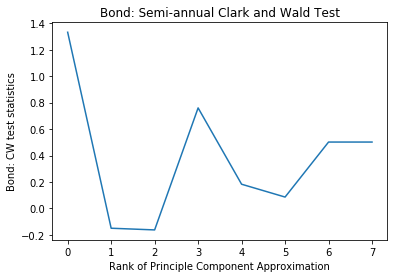

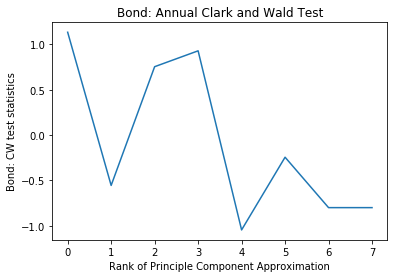

In [98]:
my_dict = {'month':200,'quarter':66,'semi':33,'annual':16}

i=0
for item in my_dict.keys():
    plt.figure(i)
    if item == 'month':
        plt.plot([CW_test(X,r,i,my_dict[item]) for i in range(X.shape[1]+1)])
        plt.xlabel('Rank of Principle Component Approximation')
        plt.ylabel('CW test statistics')
        plt.title('Bond: Month Clark and Wald Test')
    else:
        eval(f'plt.plot([CW_test(X_{item},r_{item},i,my_dict[item]) for i in range(X.shape[1]+1)])')
        plt.xlabel('Rank of Principle Component Approximation')
        plt.ylabel('Bond: CW test statistics')
        if item == 'semi':
            plt.title('Bond: '+f'{item[0].upper()}{item[1:]}' + '-annual Clark and Wald Test')
        else:
            plt.title('Bond: '+ f'{item[0].upper()}{item[1:]} Clark and Wald Test')
    i+=1

### 3.3 Bill Returns

The result is not as expected for bill returns. I suspect that the compound return data provided by the Factset is not accurate. For visualization of the data, Please refer to the next cell. The data shows the 1-month return. However, the maximum return was 10.0 and minimum value was -9. Clearly, return of -9 does not make sense. As I have checked the function I used to compute the return, I should find another source to obtain the return data. However, I do not currently know where I can retrieve the data.


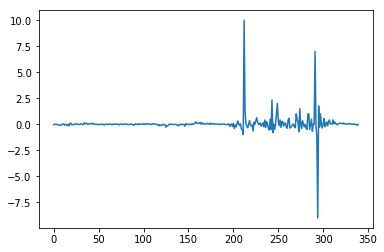

In [99]:
plt.plot( processed_df['r_bill'].values)

In [100]:
processed_df['r_bill'].values.min()

-8.999999999997765

In [101]:
X = processed_df['y_bill'].values.reshape(-1,1)
r = processed_df['r_bill'].values

X_quarter = (processed_df[2:].set_index('Dates').resample('3M')
             .agg('last')[['y_bill']].values)
y_quarter = (processed_df[2:].set_index('Dates')
             .resample('3M').agg('last')['r_bill'].values)
X_semi = (processed_df[2:].set_index('Dates').resample('6M')
          .agg('last')[['y_bill']].values)
y_semi = (processed_df[2:].set_index('Dates')
          .resample('6M').agg('last')['r_bill'].values)
X_annual = (processed_df.set_index('Dates').resample('Y')
        .agg(lambda x: x[-2])[['y_bill']].values)
y_annual = (processed_df.set_index('Dates').resample('Y')
        .agg(lambda x: x[-2])['r_bill'].values)

In [102]:
my_dict = {'month':200,'quarter':66,'semi':33,'annual':16}

i=0
for item in my_dict.keys():
    if item=='month':
        print('Month Rsquared_OS: ', Rsquared_OS(X,r,1,my_dict[item]))
    else:
        eval( f'print(item," Rsquared_OS: ",Rsquared_OS(X_{item},r_{item},1,my_dict[item]))')


Month Rsquared_OS:  -0.009179932272639357
quarter  Rsquared_OS:  -0.10034942055336504
semi  Rsquared_OS:  -0.036215348588125584
annual  Rsquared_OS:  -0.025368552452170956


In [103]:
my_dict = {'month':200,'quarter':66,'semi':33,'annual':16}

i=0
for item in my_dict.keys():
    if item=='month':
        print('Month Rsquared_OS: ', CW_test(X,r,1,my_dict[item]))
    else:
        eval( f'print(item," Rsquared_OS: ",CW_test(X_{item},r_{item},1,my_dict[item]))')


Month Rsquared_OS:  -0.15740600529154933
quarter  Rsquared_OS:  -0.5358886092568653
semi  Rsquared_OS:  0.44965609947281726
annual  Rsquared_OS:  0.0908765054611409


## 4. Portfolio Performance Evaluation

Choice of the number of Principal Components for Month:
Stock: 7, Bond: 2

## 4.1 Return Estimate

In [104]:
r_actual = processed_df[['r_SPX','r_bond','r_bill']].values

In [105]:
r_hat_SPX = []
for i in range(r_actual.shape[0]):
    X_stock_PCA = truncated_PC(processed_df[stock_explanatory_variables][:i].values,7)
    w_stock = PC_fit(X_stock_PCA,r_actual[:i,0],7)
    x_stock_PCA_new = np.concatenate((np.ones(1),truncated_PC(processed_df[stock_explanatory_variables][:i+1].values,7)[-1,:]))
    r_hat_SPX+=[np.dot(x_stock_PCA_new,w_stock)]

No handles with labels found to put in legend.


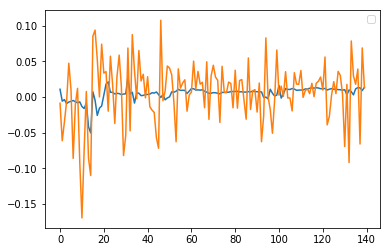

In [106]:
plt.plot(r_hat_SPX[200:])
plt.plot(r_actual[200:,0])
plt.legend()

In [107]:
r_hat_bond = []
for i in range(r_actual.shape[0]):
    X_bond_PCA = truncated_PC(processed_df[bonds_explanatory_variables][:i].values,2)
    w_bond = PC_fit(X_bond_PCA,r_actual[:i,1],2)
    x_bond_PCA_new = np.concatenate((np.ones(1),truncated_PC(processed_df[bonds_explanatory_variables][:i+1].values,2)[-1,:]))
    r_hat_bond+=[np.dot(x_bond_PCA_new,w_bond)]

No handles with labels found to put in legend.


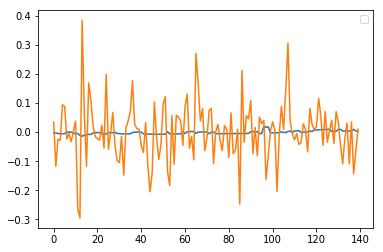

In [108]:
plt.plot(r_hat_bond[200:])
plt.plot(r_actual[200:,1])
plt.legend()

In [109]:
r_hat_bill = []
X_bill = np.concatenate((np.ones(r_actual.shape[0]).reshape(-1,1),
                         processed_df['y_bill'].values.reshape(-1,1)),axis=1)
for i in range(r_actual.shape[0]):
    w_bill = np.matmul(
                    np.matmul(
                        np.linalg.inv(1e-6*np.eye(2) + np.matmul(
                            X_bill[:i-1,:].transpose(),X_bill[:i-1,:])),
                            X_bill[:i-1,:].transpose()),
                        r_actual[:i-1,2])
    r_hat_bill+=[np.dot(X_bill[i-1,:],w_bill)]
    
    
    

No handles with labels found to put in legend.


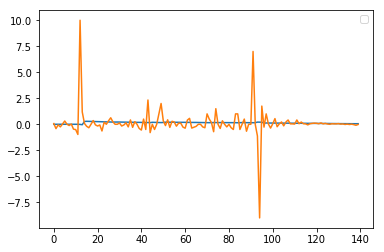

In [110]:
plt.plot(r_hat_bill[200:])
plt.plot(r_actual[200:,2])
plt.legend()

In [111]:
r_hat = pd.DataFrame(r_hat_SPX,columns = ['r_hat_SPX'])
r_hat['r_hat_bond'] = pd.Series(r_hat_bond)
r_hat['r_hat_bill'] = pd.Series(r_hat_bill)
r_hat = r_hat.astype(float)

/Users/gimdong-geon/python3_cooking/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:702: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


## 4.2 EWMA Covariance Estimate

I referred the formula of Exponentially Weighted Moving Average from Table 5.1 of Riskmetrics - technical document. It is as following:
$$Cov(r^i, r^j)= (1-\lambda)\sum_{t=0}^{T-1}\lambda^t (r_{t}^{i}-\overline{r}_{t}^{i})(r_{t}^{j}-\overline{r}_{t}^{j}) \quad i,j \in{\{stock, bond, bill\}}$$
The way I compute this amount is:
$$ X =\begin{pmatrix}
r^{stock}_0 -\overline{r}^{stock}& r^{bond}_0  -\overline{r}^{bond}& r^{bill}_0 -\overline{r}^{bill}\\ 
r^{stock}_1 -\overline{r}^{stock}&  r^{bond}_1 -\overline{r}^{bond}& r^{bill}_1 -\overline{r}^{bill}\\ 
r^{stock}_3 -\overline{r}^{stock}&  r^{bond}_2 -\overline{r}^{bond}& r^{bill}_2 -\overline{r}^{bill}
\end{pmatrix} \\
\Rightarrow
\tilde{X}=\sqrt{1-\lambda}\bigl(\begin{smallmatrix}
1 & 0 & 0\\ 
 0&  \lambda^{0.5}& 0\\ 
 0&  0& \lambda
\end{smallmatrix}\bigr)X =\sqrt{1-\lambda} \begin{pmatrix}
r^{stock}_0 -\overline{r}^{stock}& r^{bond}_0  -\overline{r}^{bond}& r^{bill}_0 -\overline{r}^{bill}\\ 
\lambda^{0.5}(r^{stock}_1 -\overline{r}^{stock})&  \lambda^{0.5}(r^{bond}_1 -\overline{r}^{bond})&\lambda^{0.5}( r^{bill}_1 -\overline{r}^{bill})\\ 
\lambda(r^{stock}_2 -\overline{r}^{stock})&  \lambda(r^{bond}_2 -\overline{r}^{bond})&\lambda( r^{bill}_2 -\overline{r}^{bill})
\end{pmatrix}= (\tilde{r}^{stock},\tilde{r}^{bond},\tilde{r}^{bill} )
\\
$$

$$\Rightarrow
\tilde{X}^T\tilde{X} = \begin{pmatrix}
 (\tilde{r}^{stock})^T\tilde{r}^{stock}& (\tilde{r}^{stock})^T\tilde{r}^{bond} &(\tilde{r}^{stock})^T\tilde{r}^{bill} \\ 
 (\tilde{r}^{bond})^T\tilde{r}^{stock}&  (\tilde{r}^{bond})^T\tilde{r}^{bond}& (\tilde{r}^{bond})^T\tilde{r}^{bill}\\ 
 (\tilde{r}^{bill})^T\tilde{r}^{stock}&  (\tilde{r}^{bill})^T\tilde{r}^{bond}& (\tilde{r}^{bill})^T\tilde{r}^{bill}
\end{pmatrix} = \begin{pmatrix}
Cov(r^{stock},r^{stock}) &  Cov(r^{stock},r^{bond})&Cov(r^{stock},r^{bill}) \\ 
Cov(r^{bond},r^{stock}) & Cov(r^{bond},r^{ond}) & Cov(r^{bond},r^{bill})\\ 
Cov(r^{bill},r^{stock}) & Cov(r^{bill},r^{bond}) & Cov(r^{bill},r^{bill})
\end{pmatrix}
$$

In [112]:
def EWMA(t):
    decay = 0.94
    A = np.matmul(np.diag([np.sqrt((1-decay)*decay**i) 
                           for i in range(t+1)]),r_actual[:t+1])
    return np.matmul(A.T,A)

In [113]:
EWMA(200)

array([[ 0.00119016, -0.00066904, -0.00047128],
       [-0.00066904,  0.00164213,  0.00131968],
       [-0.00047128,  0.00131968,  0.00323162]])

## 4.3 Black Litterman $\mu$ and $\Sigma$

### 4.3.1 Covariance Matrix of Active Views

$$\omega_{j} = \left( \frac{1-c_{j}}{c_{j}} \right)p_{j}\hat{\Sigma}_{t:t+h}p_{j}^{T}\quad \text{for} \space j = \text{stock, bond, or bill}$$
where $p_{stock}, p_{bond}, p_{bill}$ are first, second and third rows of $P = I_{3}$. And, $c_{stock} = 0.25, c_{bond} = 0.50, c_{bill} = 0.75$. Note that larger the c is, less relevant is the investor view and when c equals 1 then investor view is considered majestic. The rationale for the choice of parameter is that if regression result is credit-worthy (characterized by high $R^2_{OS}$) then do not utilize information about views.

I slightly modify the weights `c` because of poor quality of bond/bill returns data I obtained.

In [114]:
omega_stock = [(1/0.75 -1)*EWMA(t)[0,0] for t in range(r_actual.shape[0])]
omega_bond  = [(1/0.5 -1)*EWMA(t)[1,1] for t in range(r_actual.shape[0])]
omega_bill  = [(1/0.25 -1)*EWMA(t)[2,2] for t in range(r_actual.shape[0])]

In [115]:
Omega = []
for i in range(len(omega_stock)):
    Omega += [np.diag([omega_stock[i],omega_bond[i],omega_bill[i]])]

### 4.3.2 $\mu_{BL}$ And $\Sigma_{BL}$

$$\mu_{BL} = \mu + \hat{\Sigma} P^T(P\hat{\Sigma}P^T+\Omega)^{-1}(V-P \mu) $$
$$ \Sigma_{BL} = \hat{\Sigma} - \hat{\Sigma}P^T(P\hat{\Sigma}P^T+\Omega)^{-1}P\hat{\Sigma}$$

Da Silva(2009) claims that Black-Litterman was derived under the mean-variance portfolio optimization rather than optimizing the common active management performance measure, the information ratio. And, this resulted in a bias that could lead to unintentional trades.

The authors' remedy for this issue pertains to the practice of obtaining implied equilibrium excess returns through $\mu = \gamma \Sigma \omega_B$ where $\gamma$ is a risk-aversion coefficient. The author asserts to set $\mu = 0$. And, $\hat{r}$ is considered to be the active views $V$ and $P$ is assumed to be $I_3$.
In summary,
$$\mu_{BL} = \hat{\Sigma}(\hat{\Sigma}+\Omega)^{-1}\hat{r} $$
$$ \Sigma_{BL} = \hat{\Sigma} - \hat{\Sigma}(\hat{\Sigma}+\Omega)^{-1}\hat{\Sigma}$$

In [116]:
mu_BL = []
Sigma_BL = []
for i in range(len(r_actual)):
    mu_BL+=[np.dot(np.matmul(EWMA(i),np.linalg.inv(1e-6 + EWMA(i) + Omega[i])),r_hat.values[i] )]
    Sigma_BL+=[EWMA(i)-np.matmul(np.matmul(EWMA(i),np.linalg.inv(1e-6 +EWMA(i)+Omega[i])),EWMA(i))]

### 4.3.3 Black-Litterman Return Expectation and Variance

$log(r)|view \sim N(\mu_{BL},\Sigma_{BL}) \\ \Rightarrow E[P^i_{t}] = P^i_{0}exp\left(\mu_{BL,i} + \frac{1}{2} \Sigma_{BL,(i,i)}\right) \quad \text{where} \quad i\in{\{stock,bond,bill\}}
 \\ \quad Cov[P^i_{t},P^j_{t}] =P^i_{0}P^i_{0}exp\left(\mu_{BL,i}+\mu_{BL,j}\right)exp\left(\frac{1}{2}\left(\Sigma_{BL,(ii)} +   \Sigma_{BL,(jj)}\right)\right)\bigodot\left(exp\left(\Sigma_{BL,(ij)}-1\right)\right) \quad \text{where}  \quad  i,j\in{\{stock,bond,bill\}}        $

In [117]:
m=[]
S=[]
for i in range(len(r_actual)):
    m += [np.exp(mu_BL[i]+0.5*np.diag(Sigma_BL[i])).reshape(-1,1)  - 1]
    S += [np.multiply(np.matmul(np.exp(mu_BL[i]+0.5*np.diag(Sigma_BL[i])).reshape(-1,1),
          np.exp(mu_BL[i]+0.5*np.diag(Sigma_BL[i])).reshape(-1,1).T),np.exp(Sigma_BL[i]) - 1)]

### 4.3.4 DAA Portfolio Optimization

Initial attempt:

Optimization problem is:


\begin{aligned}
\max_{w} \quad & \left ( w-w_{bench} \right )^Tm\\
\textrm{s.t.} \quad & \left \| R\left ( w-w_{bench} \right )\right \|_2^2 \leq (h/12)TE^2\\
 & w^T1_3 =1    \\
 & w  \geq w_{LB}
\end{aligned}

where $R$ is the Cholesky Decomposition of $S$


In [118]:
def cholesky(A):
    """
    computes left cholesky matrix. Advantage of this matrix over np.linalg.cholesky
    is that first few observation of S matrix is not positive definite which creates
    an error message.
    """
    L = np.eye(3)
    L[1:,0]=-A[1:,0]/A[0,0]
    tmp = np.matmul(L,A)
    L2 = np.eye(3)
    L2[2,1] = -tmp[2,1]/tmp[1,1]
    diag = np.sqrt(np.matmul(np.matmul(np.matmul(L2,tmp),L.T),L2.T))
    Linv=np.eye(3)
    Linv[1:,0] = -L[1:,0]/L[0,0]
    L2inv=np.eye(3)
    L2inv[2,1] = -L2[2,1]/L2[1,1]
    Left = np.matmul(np.matmul(Linv,L2inv),diag)
    return Left

Sanity Check:

In [119]:
R = cholesky(S[20]).T
R.T - np.linalg.cholesky(S[20])

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [120]:
for i in range(len(r_actual))[:5]:
    print(cholesky(S[i]))

[[ 5.32797217e-05  0.00000000e+00  0.00000000e+00]
 [-5.73580103e-04  2.58327850e-07  0.00000000e+00]
 [-6.21356947e-03  2.69271475e-05  4.56954959e-06]]
[[      nan 0.              nan]
 [      nan 0.0007352       nan]
 [      nan 0.0078131       nan]]
[[ 0.00785924  0.          0.        ]
 [-0.000789    0.00282752  0.        ]
 [ 0.00037972  0.00165482  0.00759579]]
[[ 0.00707922  0.          0.        ]
 [-0.00119289  0.0043134   0.        ]
 [ 0.00031536  0.00185641  0.00908291]]
[[ 9.99118761e-03  0.00000000e+00  0.00000000e+00]
 [-1.14962585e-03  5.56672793e-03  0.00000000e+00]
 [ 2.54922379e-05  4.17563252e-03  7.35078286e-03]]


/Users/gimdong-geon/python3_cooking/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


S is not psd for many observations. So I avoided cholesky

\begin{aligned}
\max_{w} \quad &  w^Tm\\
\textrm{s.t.} \quad &  \left ( w-w_{bench} \right )^TS\left ( w-w_{bench} \right ) \ \leq (h/12)TE^2\\
 & w^T1_3 =1    \\
 & w  \geq w_{LB}
\end{aligned}

To get constraints, I use fstring with list comprehension as below:

In [121]:
cone = '+'.join([f'((w{i}-w_bench[{i}])*S[i][{i},{j}]*(w{j}-w_bench[{j}]))' for i in range(3) for j in range(3)])
cone

'((w0-w_bench[0])*S[i][0,0]*(w0-w_bench[0]))+((w0-w_bench[0])*S[i][0,1]*(w1-w_bench[1]))+((w0-w_bench[0])*S[i][0,2]*(w2-w_bench[2]))+((w1-w_bench[1])*S[i][1,0]*(w0-w_bench[0]))+((w1-w_bench[1])*S[i][1,1]*(w1-w_bench[1]))+((w1-w_bench[1])*S[i][1,2]*(w2-w_bench[2]))+((w2-w_bench[2])*S[i][2,0]*(w0-w_bench[0]))+((w2-w_bench[2])*S[i][2,1]*(w1-w_bench[1]))+((w2-w_bench[2])*S[i][2,2]*(w2-w_bench[2]))'

In [197]:
w_LB = 0.05*np.ones(3)
w_bench = np.array([0.65,0.3,0.05])
TE=0.02
w = np.array([np.nan,np.nan,np.nan]).reshape(-1,3)
for i in range(len(r_actual)):
    # Create a new model

        model = Model("qcp")
        model.setParam('OutputFlag', 0)
        # Create variables
        w0 = model.addVar(name="w0")
        w1 = model.addVar(name="w1")
        w2 = model.addVar(name="w2")

        # Set objective: x
        obj = m[i][0][0]*w0 + m[i][1][0]*w1 + m[i][2][0]*w2 
        model.setObjective(obj, GRB.MAXIMIZE)

        model.addConstr(w0 + w1 + w2 == 1, "c0")
        model.addConstr(w0  >= w_LB[0], "c1")
        model.addConstr(w1  >= w_LB[1], "c2")
        model.addConstr(w2  >= w_LB[2], "c3")

        # Add second-order cone: 
        eval('model.addConstr(' + cone + '<= (TE**2 *(1/12)), "qc0")')
        model.optimize()

        if i%100==0:
            print(f'{i}th observation: ')
            for v in model.getVars():
                print('%s %g' % (v.varName, v.x))
            print('Obj: %g' % obj.getValue())
        w = np.concatenate((w,np.array([model.getVars()[i].x for i in range(3)]).reshape(-1,3)))
w = w[1:,:]

0th observation: 
w0 0.0500041
w1 0.0500182
w2 0.899978
Obj: 0.00750459
100th observation: 
w0 0.817374
w1 0.132397
w2 0.050229
Obj: 0.0055681
200th observation: 
w0 0.818005
w1 0.131857
w2 0.0501372
Obj: 0.00629528
300th observation: 
w0 0.70951
w1 0.126051
w2 0.164439
Obj: 0.0125932


Text(0.5, 1.0, 'DAA stock weight')

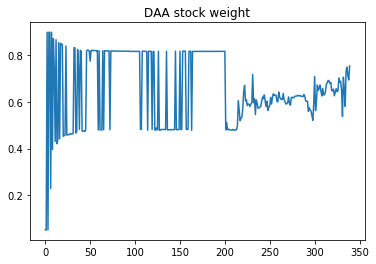

In [198]:
plt.plot(w[:,0])
plt.title("DAA stock weight")

Text(0.5, 1.0, 'DAA bond weight')

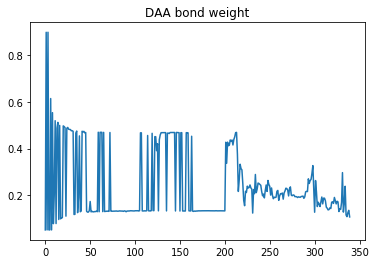

In [199]:
plt.plot(w[:,1])
plt.title("DAA bond weight")

Text(0.5, 1.0, 'DAA bill weight')

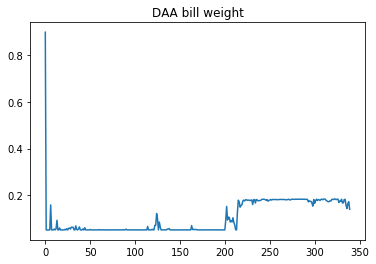

In [200]:
plt.plot(w[:,2])
plt.title("DAA bill weight")

### 4.3.5 Portfolio Performance Statistics

### 4.3.5.1 Annualized Return

Below cell tries to adjusts for erratic data. Bill return is not expected to change by 500% over a month.

In [205]:
np.place(w[:,2], np.abs(r_actual[:,2])>5, 0)
w[np.abs(r_actual[:,2])>5]

array([[0.48110419, 0.46817669, 0.        ],
       [0.60319534, 0.21560353, 0.        ],
       [0.57516302, 0.24964986, 0.        ]])

In [206]:
r_portfolio_actual = np.multiply(r_actual,w).sum(axis=1)
r_portfolio_bench = np.multiply(r_actual,w_bench).sum(axis=1)

In [207]:
DAA_geo_return = (((r_portfolio_actual[200:]+1).prod()**(1/r_portfolio_actual[200:].shape[0]))-1) * 12
DAA_geo_return

0.13076375431897436

In [208]:
Bench_geo_return =(((r_portfolio_bench[200:]+1).prod()**(1/r_portfolio_bench[200:].shape[0]))-1) * 12
Bench_geo_return 

0.0824949523121612

Annualized geometric return of DAA portfolio from November 2007 (observation index 200) to July is 13.97% and that of benchmark portfolio is 7.49%

### 4.3.5.2 Standard Deviation

In [209]:
DAA_std = r_portfolio_actual[200:].std(ddof=1)
DAA_std

0.0952343518306201

In [210]:
Bench_std = r_portfolio_bench[200:].std(ddof=1)
Bench_std

0.0772344189520475

### 4.3.5.3 Maximum Drawdown

In [211]:
DAA_mdd = -((r_portfolio_actual[200:] + 1).cumprod().min() - 1)
DAA_mdd

0.5258912498691841

In [212]:
Bench_mdd = -((r_portfolio_bench[200:] + 1).cumprod().min() - 1)
Bench_mdd

0.4146251668854053

### 4.3.5.4 Calmar Ratio

In [213]:
DAA_Calmar = DAA_geo_return/DAA_mdd
DAA_Calmar 

0.24865170194693664

In [214]:
Bench_Calmar = Bench_geo_return/Bench_mdd
Bench_Calmar

0.198962723203344

### 4.3.5.4 Average Excess Return

In [215]:
Avg_Excess_Return = DAA_geo_return - Bench_geo_return
Avg_Excess_Return

0.04826880200681316

### 4.3.5.5 Tracking Error

In [216]:
Tracking_Error = (r_portfolio_actual[200:] - r_portfolio_bench[200:]).std(ddof=1) *np.sqrt(12)
Tracking_Error

0.3114030108919141

### 4.3.5.6 Information Ratio

In [217]:
IR = Avg_Excess_Return/Tracking_Error
IR

0.1550042880721116

## 4.4 Transaction Cost and Performance Evaluation

### 4.4.1 Transaction Cost

In [218]:
transaction_cost = np.arange(0,0.0455,0.0005) # 50 basis points increments
transaction_cost

array([0.    , 0.0005, 0.001 , 0.0015, 0.002 , 0.0025, 0.003 , 0.0035,
       0.004 , 0.0045, 0.005 , 0.0055, 0.006 , 0.0065, 0.007 , 0.0075,
       0.008 , 0.0085, 0.009 , 0.0095, 0.01  , 0.0105, 0.011 , 0.0115,
       0.012 , 0.0125, 0.013 , 0.0135, 0.014 , 0.0145, 0.015 , 0.0155,
       0.016 , 0.0165, 0.017 , 0.0175, 0.018 , 0.0185, 0.019 , 0.0195,
       0.02  , 0.0205, 0.021 , 0.0215, 0.022 , 0.0225, 0.023 , 0.0235,
       0.024 , 0.0245, 0.025 , 0.0255, 0.026 , 0.0265, 0.027 , 0.0275,
       0.028 , 0.0285, 0.029 , 0.0295, 0.03  , 0.0305, 0.031 , 0.0315,
       0.032 , 0.0325, 0.033 , 0.0335, 0.034 , 0.0345, 0.035 , 0.0355,
       0.036 , 0.0365, 0.037 , 0.0375, 0.038 , 0.0385, 0.039 , 0.0395,
       0.04  , 0.0405, 0.041 , 0.0415, 0.042 , 0.0425, 0.043 , 0.0435,
       0.044 , 0.0445, 0.045 ])

In [219]:
r_sign = np.sign(r_portfolio_actual)

In [220]:
transaction_df = processed_df[['Dates']]
transaction_df['tc_0_bp'] = r_portfolio_actual 
for i in range(1,len(transaction_cost)):
    string = f'transaction_df["tc_{i*50}_bp"] = np.multiply(r_portfolio_actual,'
    string += '(1-r_sign*transaction_cost[i]))'
    exec(string)
transaction_df.set_index('Dates', inplace=True)

/Users/gimdong-geon/python3_cooking/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/gimdong-geon/python3_cooking/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [221]:
transaction_df.head()

,tc_0_bp,tc_50_bp,tc_100_bp,tc_150_bp,tc_200_bp,tc_250_bp,tc_300_bp,tc_350_bp,tc_400_bp,tc_450_bp,...,tc_4050_bp,tc_4100_bp,tc_4150_bp,tc_4200_bp,tc_4250_bp,tc_4300_bp,tc_4350_bp,tc_4400_bp,tc_4450_bp,tc_4500_bp
Dates,,,,,,,,,,,,,,,,,,,,,
1991-03-29,-0.036231,-0.036249,-0.036267,-0.036285,-0.036303,-0.036321,-0.036340,-0.036358,-0.036376,-0.036394,...,-0.037698,-0.037716,-0.037734,-0.037753,-0.037771,-0.037789,-0.037807,-0.037825,-0.037843,-0.037861
1991-04-30,0.006605,0.006602,0.006598,0.006595,0.006592,0.006589,0.006585,0.006582,0.006579,0.006575,...,0.006338,0.006334,0.006331,0.006328,0.006324,0.006321,0.006318,0.006314,0.006311,0.006308
1991-05-31,-0.041896,-0.041917,-0.041938,-0.041959,-0.041980,-0.042001,-0.042022,-0.042043,-0.042064,-0.042085,...,-0.043593,-0.043614,-0.043635,-0.043656,-0.043677,-0.043698,-0.043719,-0.043740,-0.043761,-0.043782
1991-06-28,-0.002216,-0.002217,-0.002218,-0.002220,-0.002221,-0.002222,-0.002223,-0.002224,-0.002225,-0.002226,...,-0.002306,-0.002307,-0.002308,-0.002309,-0.002310,-0.002312,-0.002313,-0.002314,-0.002315,-0.002316
1991-07-31,0.013559,0.013552,0.013545,0.013538,0.013531,0.013525,0.013518,0.013511,0.013504,0.013497,...,0.013009,0.013003,0.012996,0.012989,0.012982,0.012975,0.012969,0.012962,0.012955,0.012948


In [222]:
r_sign_bench = np.sign(r_portfolio_bench)

transaction_benchmark_df = processed_df[['Dates']]
transaction_benchmark_df['tc_0_bp'] = r_portfolio_bench 
for i in range(1,len(transaction_cost)):
    string = f'transaction_benchmark_df["tc_{i*50}_bp"] = np.multiply(r_portfolio_bench,'
    string += '(1-r_sign_bench*transaction_cost[i]))'
    exec(string)
transaction_benchmark_df.set_index('Dates', inplace=True)

/Users/gimdong-geon/python3_cooking/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/gimdong-geon/python3_cooking/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [223]:
transaction_benchmark_df.head()

,tc_0_bp,tc_50_bp,tc_100_bp,tc_150_bp,tc_200_bp,tc_250_bp,tc_300_bp,tc_350_bp,tc_400_bp,tc_450_bp,...,tc_4050_bp,tc_4100_bp,tc_4150_bp,tc_4200_bp,tc_4250_bp,tc_4300_bp,tc_4350_bp,tc_4400_bp,tc_4450_bp,tc_4500_bp
Dates,,,,,,,,,,,,,,,,,,,,,
1991-03-29,-0.002896,-0.002898,-0.002899,-0.002901,-0.002902,-0.002904,-0.002905,-0.002906,-0.002908,-0.002909,...,-0.003014,-0.003015,-0.003016,-0.003018,-0.003019,-0.003021,-0.003022,-0.003024,-0.003025,-0.003027
1991-04-30,0.026753,0.026740,0.026726,0.026713,0.026700,0.026686,0.026673,0.026659,0.026646,0.026633,...,0.025670,0.025656,0.025643,0.025629,0.025616,0.025603,0.025589,0.025576,0.025563,0.025549
1991-05-31,-0.024340,-0.024352,-0.024364,-0.024377,-0.024389,-0.024401,-0.024413,-0.024425,-0.024437,-0.024450,...,-0.025326,-0.025338,-0.025350,-0.025362,-0.025375,-0.025387,-0.025399,-0.025411,-0.025423,-0.025435
1991-06-28,0.027612,0.027598,0.027584,0.027571,0.027557,0.027543,0.027529,0.027515,0.027502,0.027488,...,0.026494,0.026480,0.026466,0.026452,0.026439,0.026425,0.026411,0.026397,0.026383,0.026369
1991-07-31,-0.002939,-0.002941,-0.002942,-0.002943,-0.002945,-0.002946,-0.002948,-0.002949,-0.002951,-0.002952,...,-0.003058,-0.003060,-0.003061,-0.003062,-0.003064,-0.003065,-0.003067,-0.003068,-0.003070,-0.003071


### 4.4.2 Performance Evaluation

### 4.4.2.1 Annualized Return

In [224]:
tc_perf_df = pd.DataFrame([f'{i*50} bp' for i in range(0,len(transaction_cost))])
tc_perf_df.columns=['transaction_cost']

In [225]:
tc_return = []
tc_bench_return = []
for i in range(0,len(transaction_cost)):
    string = f"tc_return += [(((transaction_df['tc_{i*50}_bp'].values[200:]+1)"
    string += f'.prod()**(1/transaction_df["tc_{i*50}_bp"].values[200:].shape[0]))-1) * 12]'
    exec(string)
    string2 = f"tc_bench_return += [(((transaction_benchmark_df['tc_{i*50}_bp'].values[200:]+1)"
    string2 += f'.prod()**(1/transaction_benchmark_df["tc_{i*50}_bp"].values[200:].shape[0]))-1) * 12]'
    exec(string2)

In [226]:
tc_perf_df['annual_return'] = tc_return
tc_perf_df['annual_return_bench'] = tc_bench_return

In [227]:
tc_perf_df.head()

,transaction_cost,annual_return,annual_return_bench
0,0 bp,0.130764,0.082495
1,50 bp,0.130371,0.082196
2,100 bp,0.129977,0.081897
3,150 bp,0.129584,0.081598
4,200 bp,0.129191,0.081300


### 4.4.2.2 Standard Deviation

In [228]:
tc_perf_df['std'] = [eval(f'transaction_df["tc_{i*50}_bp"].values[200:].std(ddof=1)')
                                    for i in range(0,len(transaction_cost))]

In [229]:
tc_perf_df['std_bench'] = [eval(f'transaction_benchmark_df["tc_{i*50}_bp"].values[200:].std(ddof=1)')
                                    for i in range(0,len(transaction_cost))]

In [230]:
tc_perf_df.head()

,transaction_cost,annual_return,annual_return_bench,std,std_bench
0,0 bp,0.130764,0.082495,0.095234,0.077234
1,50 bp,0.130371,0.082196,0.095222,0.077230
2,100 bp,0.129977,0.081897,0.095209,0.077226
3,150 bp,0.129584,0.081598,0.095196,0.077221
4,200 bp,0.129191,0.081300,0.095184,0.077217


### 4.4.2.3 Maximum Drawdown

In [231]:
tc_perf_df['max_drawdown'] = [eval(f'(transaction_df["tc_{i*50}_bp"].values[200:]+1).cumprod().min()')
                                    for i in range(0,len(transaction_cost))]

In [232]:
tc_perf_df['max_drawdown_bench'] = [eval(f'(transaction_benchmark_df["tc_{i*50}_bp"].values[200:]+1).cumprod().min()')
                                    for i in range(0,len(transaction_cost))]

In [233]:
tc_perf_df.head()

,transaction_cost,annual_return,annual_return_bench,std,std_bench,max_drawdown,max_drawdown_bench
0,0 bp,0.130764,0.082495,0.095234,0.077234,0.474109,0.585375
1,50 bp,0.130371,0.082196,0.095222,0.077230,0.473852,0.585139
2,100 bp,0.129977,0.081897,0.095209,0.077226,0.473596,0.584904
3,150 bp,0.129584,0.081598,0.095196,0.077221,0.473339,0.584668
4,200 bp,0.129191,0.081300,0.095184,0.077217,0.473083,0.584433


### 4.4.2.4 Calmar Ratio

In [234]:
tc_perf_df['calmar'] = tc_perf_df['annual_return'].values/tc_perf_df['max_drawdown'].values

In [235]:
tc_perf_df['calmar_bench'] = tc_perf_df['annual_return_bench'].values/tc_perf_df['max_drawdown_bench'].values

In [236]:
tc_perf_df.head()

,transaction_cost,annual_return,annual_return_bench,std,std_bench,max_drawdown,max_drawdown_bench,calmar,calmar_bench
0,0 bp,0.130764,0.082495,0.095234,0.077234,0.474109,0.585375,0.275810,0.140927
1,50 bp,0.130371,0.082196,0.095222,0.077230,0.473852,0.585139,0.275129,0.140473
2,100 bp,0.129977,0.081897,0.095209,0.077226,0.473596,0.584904,0.274448,0.140018
3,150 bp,0.129584,0.081598,0.095196,0.077221,0.473339,0.584668,0.273766,0.139564
4,200 bp,0.129191,0.081300,0.095184,0.077217,0.473083,0.584433,0.273083,0.139108


### 4.4.2.5 Average Excess Return

In [237]:
tc_perf_df['avg_excess_return'] = tc_perf_df['annual_return'] - tc_perf_df['annual_return_bench']

In [238]:
tc_perf_df.head()

,transaction_cost,annual_return,annual_return_bench,std,std_bench,max_drawdown,max_drawdown_bench,calmar,calmar_bench,avg_excess_return
0,0 bp,0.130764,0.082495,0.095234,0.077234,0.474109,0.585375,0.275810,0.140927,0.048269
1,50 bp,0.130371,0.082196,0.095222,0.077230,0.473852,0.585139,0.275129,0.140473,0.048174
2,100 bp,0.129977,0.081897,0.095209,0.077226,0.473596,0.584904,0.274448,0.140018,0.048080
3,150 bp,0.129584,0.081598,0.095196,0.077221,0.473339,0.584668,0.273766,0.139564,0.047986
4,200 bp,0.129191,0.081300,0.095184,0.077217,0.473083,0.584433,0.273083,0.139108,0.047891


### 4.4.2.6 Tracking Error

In [239]:
string = f'(transaction_df["tc_{i*50}_bp"].values[200:] '
string += f'- transaction_benchmark_df["tc_{i*50}_bp"].values[200:]).std(ddof=1)*np.sqrt(12)'
tc_perf_df['tracking_error'] = [eval(string) for i in range(0,len(transaction_cost))]

In [240]:
tc_perf_df.head()

,transaction_cost,annual_return,annual_return_bench,std,std_bench,max_drawdown,max_drawdown_bench,calmar,calmar_bench,avg_excess_return,tracking_error
0,0 bp,0.130764,0.082495,0.095234,0.077234,0.474109,0.585375,0.275810,0.140927,0.048269,0.306196
1,50 bp,0.130371,0.082196,0.095222,0.077230,0.473852,0.585139,0.275129,0.140473,0.048174,0.306196
2,100 bp,0.129977,0.081897,0.095209,0.077226,0.473596,0.584904,0.274448,0.140018,0.048080,0.306196
3,150 bp,0.129584,0.081598,0.095196,0.077221,0.473339,0.584668,0.273766,0.139564,0.047986,0.306196
4,200 bp,0.129191,0.081300,0.095184,0.077217,0.473083,0.584433,0.273083,0.139108,0.047891,0.306196


### 4.3.2.7 Information Ratio

In [241]:
tc_perf_df['IR'] = tc_perf_df['avg_excess_return'].values/tc_perf_df['tracking_error'].values

In [242]:
tc_perf_df.head()

,transaction_cost,annual_return,annual_return_bench,std,std_bench,max_drawdown,max_drawdown_bench,calmar,calmar_bench,avg_excess_return,tracking_error,IR
0,0 bp,0.130764,0.082495,0.095234,0.077234,0.474109,0.585375,0.275810,0.140927,0.048269,0.306196,0.157640
1,50 bp,0.130371,0.082196,0.095222,0.077230,0.473852,0.585139,0.275129,0.140473,0.048174,0.306196,0.157332
2,100 bp,0.129977,0.081897,0.095209,0.077226,0.473596,0.584904,0.274448,0.140018,0.048080,0.306196,0.157024
3,150 bp,0.129584,0.081598,0.095196,0.077221,0.473339,0.584668,0.273766,0.139564,0.047986,0.306196,0.156716
4,200 bp,0.129191,0.081300,0.095184,0.077217,0.473083,0.584433,0.273083,0.139108,0.047891,0.306196,0.156408


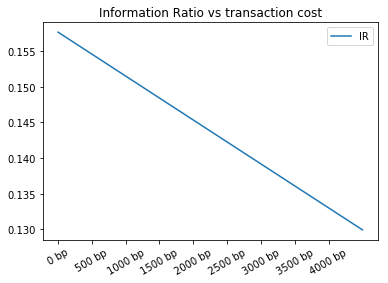

In [243]:
plt.plot('transaction_cost','IR',data=tc_perf_df)
plt.title('Information Ratio vs transaction cost')
plt.xticks(np.arange(0,90,10),rotation=30)
plt.legend()

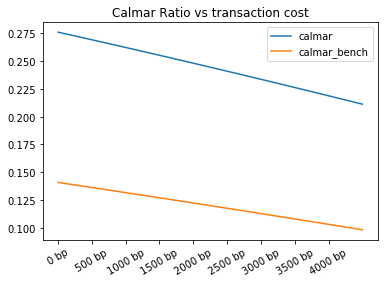

In [244]:
plt.plot('transaction_cost','calmar',data=tc_perf_df)
plt.plot('transaction_cost','calmar_bench',data=tc_perf_df)
plt.title('Calmar Ratio vs transaction cost')
plt.xticks(np.arange(0,90,10),rotation=30)
plt.legend()

### 5. Data Export

Exporting data to csv

In [246]:
weights_df = pd.DataFrame(w)
weights_df['Dates'] = processed_df['Dates']
weights_df.columns = ['w_stock','w_bond','w_bill','Dates']
weights_df.to_csv('weight.csv')